# Airbus Ship Detection Challenge

In this Jupyter Notebook I will try to solve the legendary kaggle competition - <a href='https://www.kaggle.com/competitions/airbus-ship-detection'>Airbus Ship Detection Challenge</a>.This competition encourages participants to develop a model for the rapid and accurate detection of all ships in satellite images. We will review the data and build a Unet model for binary semantic segmentation.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import seaborn as sns
import tensorflow as tf
import os

## Prepare the Dataset

Let's define train and test directories and see how many images we have.

In [2]:
train_dir = 'F:/Ship_Dataset/train_v2/'
test_dir = 'F:/Ship_Dataset/test_v2/'

train = os.listdir(train_dir)
print(len(train))

test = os.listdir(test_dir)
print(len(test))

192556
15606


In this dataset, image masks are represented as RLE encoded, so to get them you need to write the following functions. 

RLE (Run-Length Encoding) is a data compression technique that reduces information size by encoding repeated sequences, often utilized in image processing to efficiently represent masks or areas with consecutive identical values.

In [3]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
masks = pd.read_csv('F:/Ship_Dataset/train_ship_segmentations_v2.csv')
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

Let's see what our data looks like.

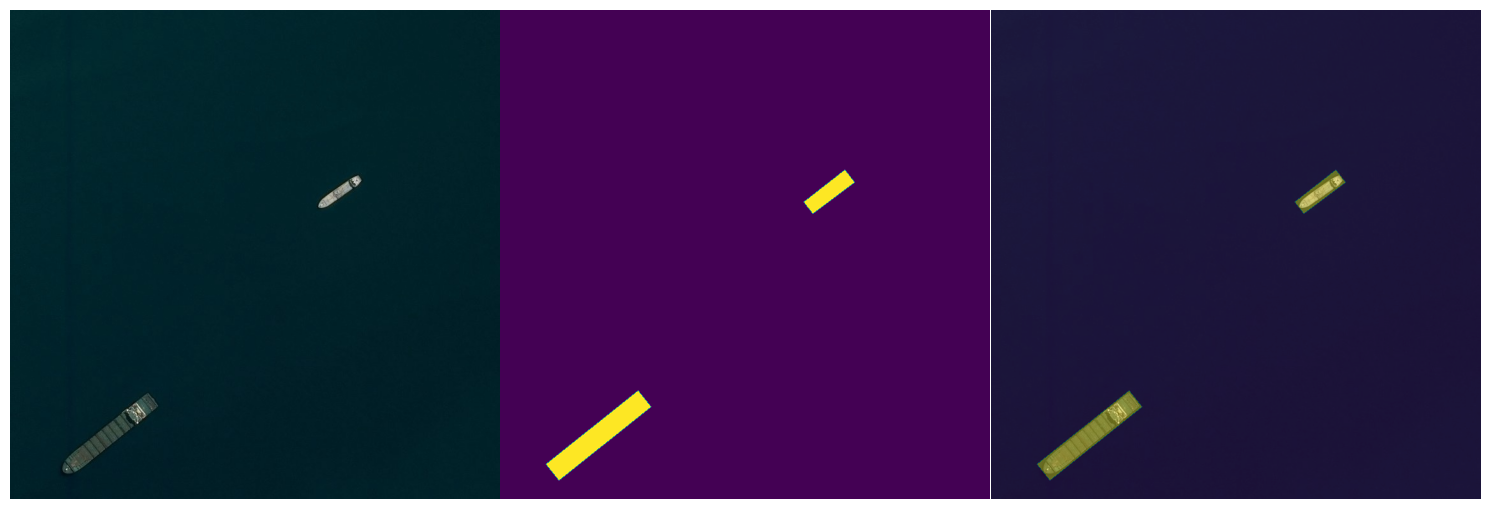

In [5]:
ImageId = '0005d01c8.jpg'

img = imread(train_dir + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

mask = masks_as_image(img_masks)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(mask)
axarr[2].imshow(img)
axarr[2].imshow(mask, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

Now let's count the number of ships in the picture and see if they are.

In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

images_df = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
images_df['has_ships'] = images_df['ships'].map(lambda x: True if x > 0 else False)

masks.drop(['ships'], axis=1, inplace=True)

images_df.head()

ImageId  ships  has_ships
0  00003e153.jpg      0      False
1  0001124c7.jpg      0      False
2  000155de5.jpg      1       True
3  000194a2d.jpg      5       True
4  0001b1832.jpg      0      False

Let's check the percentage of images with and without ships.

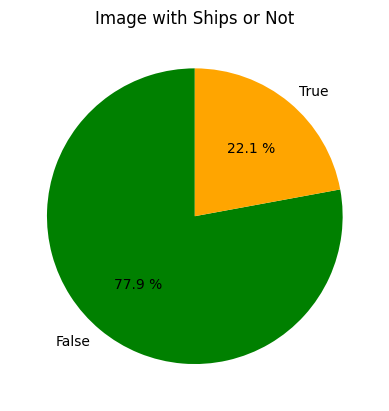

In [7]:
plt.pie(
    x = (images_df['has_ships'].value_counts()/images_df.shape[0]).values, 
    labels = (images_df['has_ships'].value_counts()/images_df.shape[0]).index,
    autopct = '%3.1f %%',
    startangle  = 90,
    colors=['green', 'orange']
)

plt.title('Image with Ships or Not')
plt.show()

As we can see in this dataset, the pictures without ships are much more prevalent, almost 80%, which is not very good for training our model, it can lead to overfiting for pictures without ships, so next I'm going to change this proportion so that the number of pictures without ships is about 30%.

In [8]:
images_with_ships_count = images_df['has_ships'].value_counts()[1]
images_withot_ships_count = images_df['has_ships'].value_counts()[0]

sample_to_remove_size = images_withot_ships_count - round(images_with_ships_count * 0.3)
sample_to_remove = images_df.loc[images_df['has_ships'] == False].sample(sample_to_remove_size)

images_df = images_df.drop(sample_to_remove.index)
images_df.shape

(55323, 3)

Let's take a look at the new proportion.

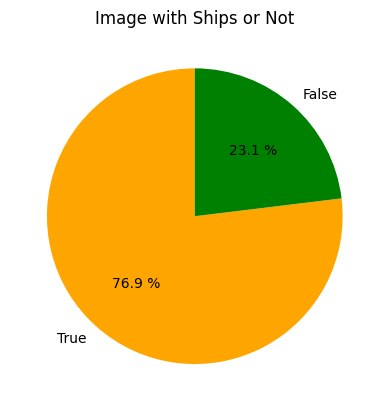

In [9]:
plt.pie(
    x = (images_df['has_ships'].value_counts()/images_df.shape[0]).values, 
    labels = (images_df['has_ships'].value_counts()/images_df.shape[0]).index,
    autopct = '%3.1f %%',
    startangle  = 90,
    colors=['orange', 'green']
)

plt.title('Image with Ships or Not')
plt.show()

That's much better, now let's look at the number of ships.

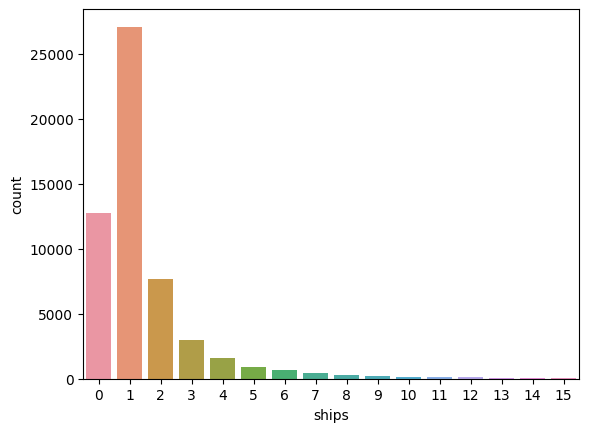

(55323, 3)

In [10]:
sns.countplot(images_df, x='ships')
plt.show()

images_df.shape

## Split data

Prepare the data and split it into train and valid datasets.

In [11]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(images_df, test_size = 0.02, stratify = images_df['ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

92590 training masks
1900 validation masks


Determine the Batch size. It will be 32. Also set such a parameter as IMG_SCALING, it will reduce our image by 3 times, which will save our computing resources.

In [12]:
BATCH_SIZE = 32
IMG_SCALING = (3, 3)
model_path = 'E:/learn/airbus-ship-detection/'

### Custom Data Generator

I will write my own custom generator to extract the images from directories during the training.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, in_df, batch_size=BATCH_SIZE, augmentation=True):
        self.all_batches = list(in_df.groupby('ImageId'))
        self.batch_size = batch_size
        self.augmentation = augmentation

        self.datagen_dict = dict(
            horizontal_flip=True,
            vertical_flip = True,
            )

        self.image_datagen = ImageDataGenerator(**self.datagen_dict)
        self.mask_datagen = ImageDataGenerator(**self.datagen_dict)

    def __len__(self):
        return int(np.ceil(len(self.all_batches) / self.batch_size))

    def __getitem__(self, idx):
        batch_pairs = self.all_batches[idx * self.batch_size:(idx + 1) * self.batch_size]

        out_rgb = []
        out_mask = []

        for c_img_id, c_masks in batch_pairs:
            seed = np.random.choice(range(9999))
            
            rgb_path = os.path.join(train_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)

            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]

            if self.augmentation:
                c_img = self.image_datagen.random_transform(c_img, seed=seed)
                c_mask = self.mask_datagen.random_transform(c_mask, seed=seed)

            out_rgb += [c_img]
            out_mask += [c_mask]
        
        return np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)

Let's check the shapes of our batches.

In [14]:
train_gen = CustomDataGen(train_df)
print(train_gen)

train_batch_x, train_batch_y = next(iter(train_gen))
print('Image shape: ', train_batch_x.shape)
print('Mask shape: ', train_batch_y.shape)

Image shape:  (32, 256, 256, 3)
Mask shape:  (32, 256, 256, 1)


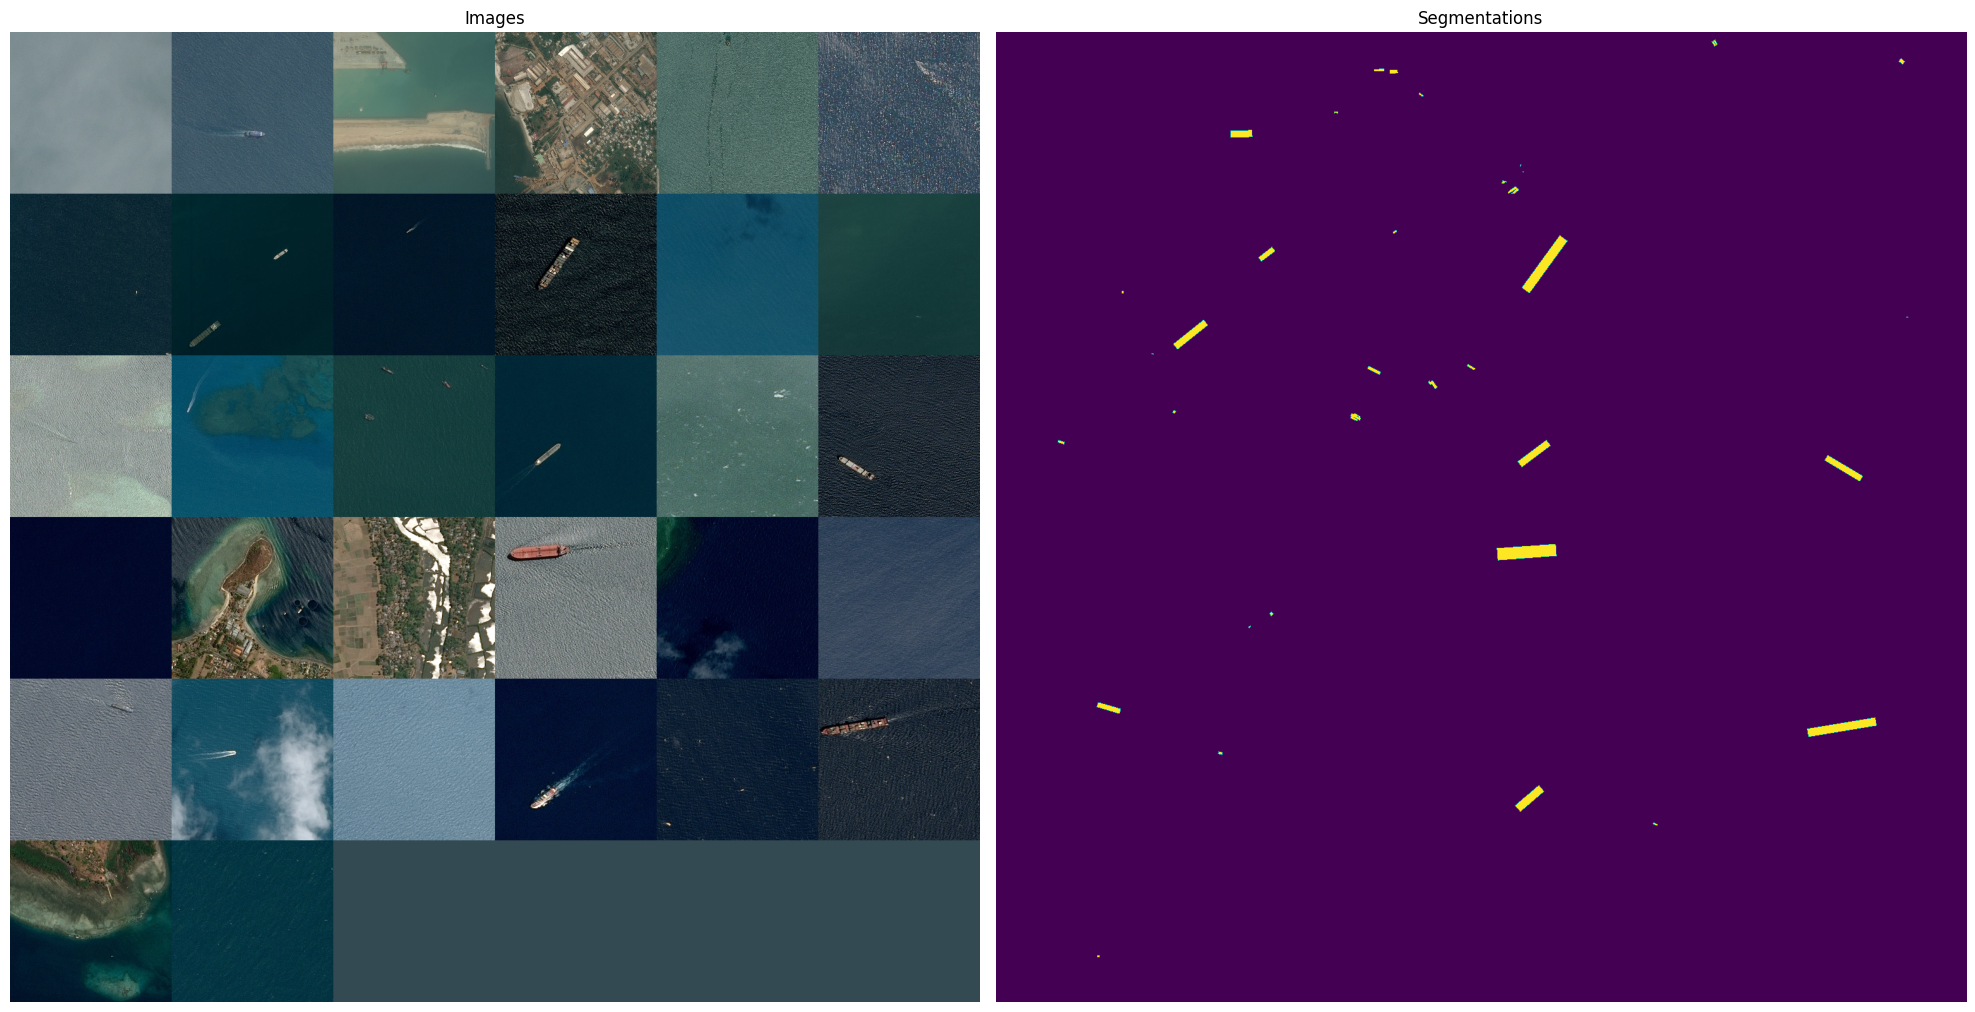

In [15]:
from skimage.segmentation import mark_boundaries
from skimage.util import montage 

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
batch_rgb = montage_rgb(train_batch_x)
batch_seg = montage(train_batch_y[:, :, :, 0])
ax1.axis('off')
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.axis('off')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

## Build the Model

Let's build Unet model. This model will do the semantic segmentatin task well. We will use VGG19 as a backbone.

In [16]:
from tensorflow import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Concatenate, Activation
from keras.models import Model
from tensorflow.keras.applications import VGG19

In [17]:
def conv_block(inputs, no_filters):
    x = Conv2D(no_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(no_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs, skip_features, no_filters):
    x = Conv2DTranspose(no_filters, (2, 2), strides=2, padding="same")(inputs)

    x = Concatenate(axis=3)([skip_features, x])
    x = conv_block(x, no_filters)
    return x

In [18]:
def build_vgg19_unet(input_shape):
    """ Input """
    input_imgs = Input(input_shape, name = 'RGB_Input')

    """ Pretrained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=input_imgs)
    
#     vgg19.trainable = False

    """ Skip Features """
    e1 = vgg19.layers[2].output
    e2 = vgg19.layers[5].output
    e3 = vgg19.layers[10].output
    e4 = vgg19.layers[15].output

    """ Bridge """
    b1 = vgg19.layers[20].output

    """ Decoder """
    d1 = decoder_block(b1, e4, 64)
    d2 = decoder_block(d1, e3, 32)
    d3 = decoder_block(d2, e2, 16)
    d4 = decoder_block(d3, e1, 8)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(input_imgs, outputs)
    return model

In [19]:
model = build_vgg19_unet(train_batch_x.shape[1:])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['RGB_Input[0][0]']              
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

## Metrics and Loss functiom

I will be using the Dice Coefficient metric and the IoU (Intersection over Union) cost function to evaluate the model's performance in the image segmentation task.

<b>Dice Coefficient</b><br>
Dice Coefficient measures the similarity between the predicted and actual masks by calculating the ratio of similar pixels between them. It ranges from 0 to 1, where 0 indicates no pixels in common and 1 indicates complete identity of the masks. Using this metric, you can evaluate the accuracy of the region of interest mapping.

<b>Intersection over Union (IoU)</b><br>
IoU calculates the ratio of the intersection area between the predicted and actual masks before they are united. This metric also expresses the degree of similarity between masks, and the value ranges from 0 to 1. The maximum value of IoU is 1 when the predicted mask is exactly the same as the actual mask.

I chose these metrics because they provide clear and interpretable values to measure the quality of segmentation, simplifying the process of evaluating the model results.

In [20]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

def IoU(y_true, y_pred, eps=1e-6):
    y_true = K.cast(y_true, dtype='float32') 
    y_pred = K.cast(y_pred, dtype='float32') 

    if K.max(y_true) == 0.0:
        y_true = 1 - y_true
        y_pred = 1 - y_pred
    
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32') 
    y_pred = K.cast(y_pred, dtype='float32') 

    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
    
weight_path="{}_weights.best.hdf5".format(model_path)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

callbacks_list = [checkpoint]

In [22]:
train_generator = CustomDataGen(train_df)
valid_x, valid_y = next(iter(CustomDataGen(valid_df, 900)))

## Train the Model

In [23]:
model.compile(optimizer=Adam(1e-3), loss=IoU, metrics=[dice_coef, 'binary_accuracy'])

loss_history = [model.fit(
    train_generator, 
    steps_per_epoch=20, 
    epochs=500,
    validation_data=(valid_x, valid_y),
    callbacks=callbacks_list,
    verbose=1
        )]

Epoch 1/500
20/20 [==============================] - ETA: 0s - loss: -0.0084 - dice_coef: 0.0161 - binary_accuracy: 0.5744
Epoch 1: val_loss improved from inf to -0.00593, saving model to E:/learn/airbus-ship-detection\_weights.best.hdf5
20/20 [==============================] - 37s 1s/step - loss: -0.0084 - dice_coef: 0.0161 - binary_accuracy: 0.5744 - val_loss: -0.0059 - val_dice_coef: 0.0115 - val_binary_accuracy: 0.2827
Epoch 2/500
20/20 [==============================] - ETA: 0s - loss: -0.0164 - dice_coef: 0.0293 - binary_accuracy: 0.5840
Epoch 2: val_loss did not improve from -0.00593
20/20 [==============================] - 20s 974ms/step - loss: -0.0164 - dice_coef: 0.0293 - binary_accuracy: 0.5840 - val_loss: -0.0057 - val_dice_coef: 0.0110 - val_binary_accuracy: 0.1086
Epoch 3/500
20/20 [==============================] - ETA: 0s - loss: -0.0230 - dice_coef: 0.0383 - binary_accuracy: 0.6502
Epoch 3: val_loss improved from -0.00593 to -0.00730, saving model to E:/learn/airbus-s

In [35]:
model.load_weights(weight_path)
model.save('Unet_model.h5')

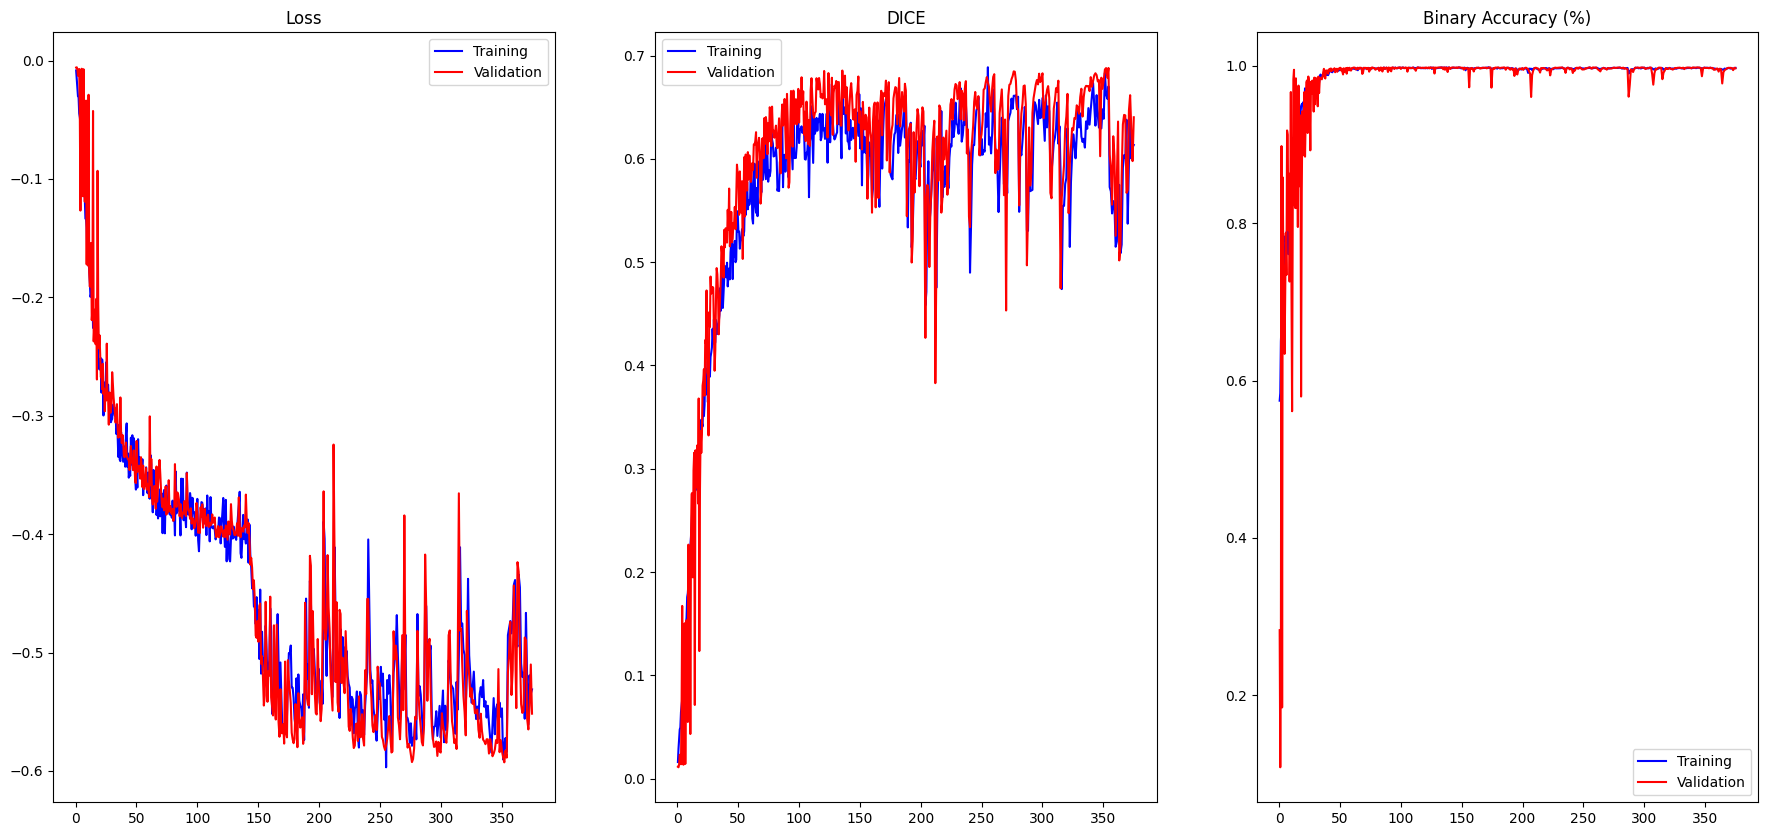

In [25]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('DICE')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    plt.savefig('losses.png')

show_loss(loss_history)

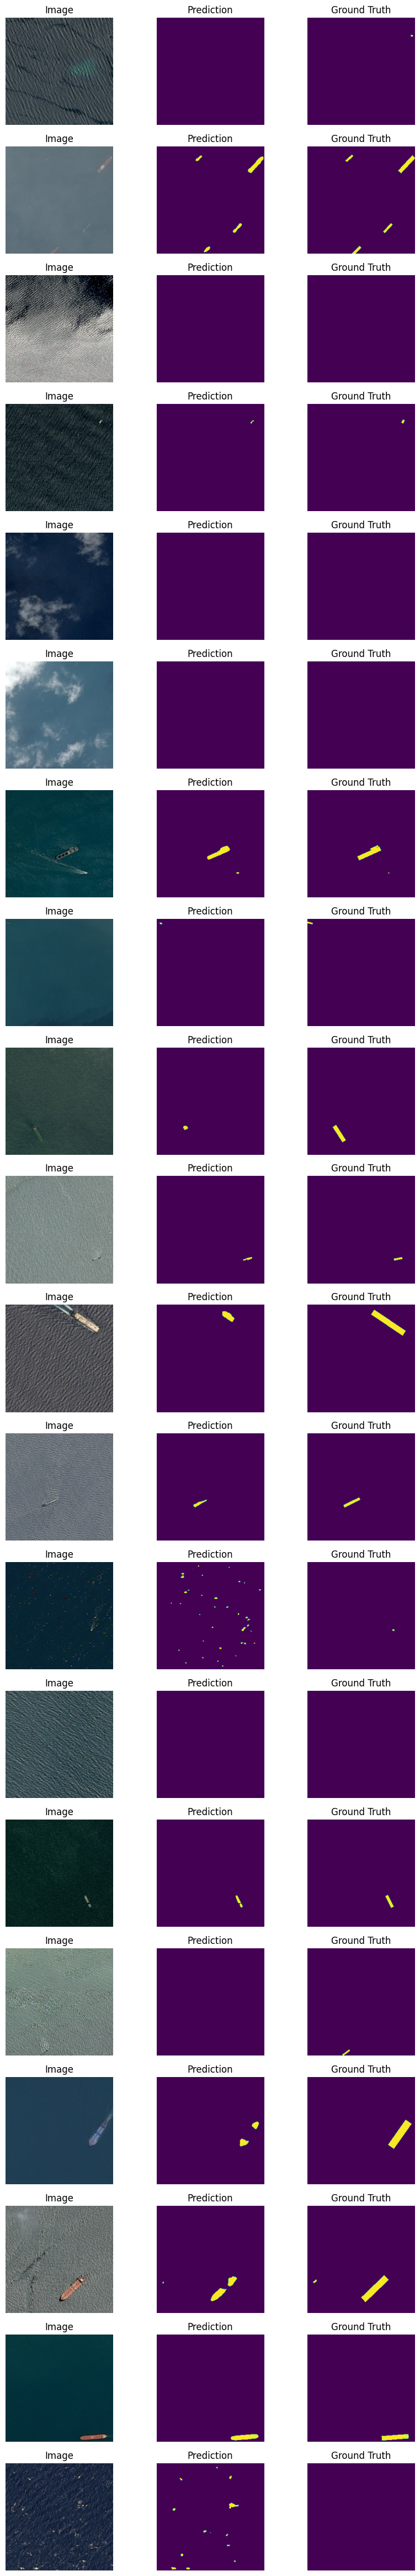

In [41]:
fig, m_axs = plt.subplots(20, 3, figsize = (10, 60))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
valid_imgs = list(valid_df.groupby('ImageId'))
for (ax1, ax2, ax3), (c_img_name, c_masks) in zip(m_axs, valid_imgs):
    c_path = os.path.join(train_dir, c_img_name)
    c_img = imread(c_path)
    img = np.expand_dims(c_img, 0)/255.0
    if IMG_SCALING is not None:
        img = img[:, ::IMG_SCALING[0], ::IMG_SCALING[1]]
    seg = model.predict(img)
    mask = masks_as_image(c_masks['EncodedPixels'].values)
    if IMG_SCALING is not None:
        mask = mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
    ax1.imshow(img[0])
    ax1.set_title('Image')
    ax2.imshow(seg[0, :, :, 0], vmin = 0, vmax = 1)
    ax2.set_title('Prediction')
    ax3.imshow(mask[:, :, 0])
    ax3.set_title('Ground Truth')
    plt.tight_layout
plt.savefig('image_pred_ground_truth.png')

## Conclusion

Before last block(Kaggle submission). Let's draw some conclusions.

Our model coped well with the task and showed good results. Let's look at how to improve the results, firstly, not to reduce the image size to 256x256 but to leave 768x768, but in my case it was impossible due to limited computing resources, secondly, you can change the architecture, for example, use ResNet50, ResNet18 as a backbone, but during the experiment VGG19 showed better results, you can also increase the model itself, increase the number of filters, layers, etc.

Overall, it was an interesting project that expanded my knowledge of working with semantic segmentation problems.

## Kaggle submission

In [29]:
from scipy import ndimage

def split_mask(mask):
    threshold = 0.6
    threshold_obj = 8 #ignor predictions composed of "threshold_obj" pixels or less
    labeled,n_objs = ndimage.label(mask > threshold)
    result = []
    for i in range(n_objs):
        obj = (labeled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result

In [31]:
def predict(img_name):
    c_path = os.path.join(test_dir, img_name)
    c_img = imread(c_path)
    img = np.expand_dims(c_img, 0)/255.0
    if IMG_SCALING is not None:
        img = img[:, ::IMG_SCALING[0], ::IMG_SCALING[1]]
    return img, model.predict(img) 

def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_run_length_encoded_predictions(y_pred, img_name):
    list_dict = []
    masks = split_mask(y_pred)
    if len(masks) == 0:
        list_dict.append({"ImageId": img_name, "EncodedPixels": np.nan})
    for mask in masks:
        list_dict.append({"ImageId": img_name, "EncodedPixels": rle_encode(mask)})
    return list_dict

def predict_and_decode(test_img_names):
    list_dict = []
    for img_name in test_img_names:
        _ , pred = predict(img_name)
        rle_pred = get_run_length_encoded_predictions(pred[0], img_name)
        list_dict += rle_pred
    return pd.DataFrame(list_dict, columns=["ImageId", "EncodedPixels"])    

In [34]:
test_decoded_pred_df = predict_and_decode(os.listdir(test_dir))
test_decoded_pred_df.to_csv('submission.csv', index=False)
test_decoded_pred_df

ImageId                                      EncodedPixels
0      00002bd58.jpg                                                NaN
1      00015efb6.jpg                                                NaN
2      00023d5fc.jpg                                                NaN
3      000367c13.jpg                    52766 1 53021 3 53277 3 53534 2
4      000367c13.jpg  8998 1 9251 6 9506 7 9762 7 10018 7 10275 6 10...
...              ...                                                ...
23150  ffeba1475.jpg            62020 1 62275 3 62531 3 62787 3 63043 2
23151  ffeba1475.jpg     691 2 946 4 1202 4 1458 4 1714 3 1971 2 2227 1
23152  ffeba1475.jpg    56536 3 56792 4 57048 4 57304 4 57561 3 57818 2
23153  ffeba1475.jpg            42232 2 42486 4 42742 4 42998 4 43256 1
23154  fff0fd44f.jpg                                                NaN

[23155 rows x 2 columns]